In [20]:
import sys, os, re
import importlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d
from scipy.stats import binned_statistic
import pickle
import pandas as pd
import yaml
import copy
import glob 
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"

sys.path.append('barcode')
import barcode
# importlib.reload(barcode.barcode_util)
# importlib.reload(barcode.extract_barcodes)
# importlib.reload(barcode.align_barcodes)

from barcode.extract_barcodes import extract_barcode
from barcode.align_barcodes import align_barcode
from barcode.barcode_util import read_h5, read_h5_with_key

import neural_analysis_helpers
importlib.reload(neural_analysis_helpers)
from neural_analysis_helpers import get_rewards, get_rewarded_landmarks, get_landmark_category_entries, get_landmark_category_rew_idx, \
    get_landmark_categories, load_vr_behaviour_data, load_nidaq_behaviour_data, get_lm_entry_exit, load_vr_session_info, get_position_info, \
    get_VR_rewards


In [2]:
# Define relevant directories and session specific info
basepath = Path('/Volumes/mrsic_flogel/public/projects/AtApSuKuSaRe_20250129_HFScohort2')

# session = 'TAA0000066/ses-011_date-20250315_protocol-t5'
# session = 'TAA0000066/ses-012_date-20250318_protocol-t6'
# session = 'TAA0000066/ses-018_date-20250403_protocol-t12'
session = 'TAA0000066/ses-010_date-20250314_protocol-t4'
sess_data_path = basepath / session
func_img_path = 'funcimg/Session'
behav_dir = sess_data_path / 'behav'

# Extract protocol number
match = re.search(r'protocol-t(\d+)', session)
if match:
    protocol_number = int(match.group(1))
else:
    raise ValueError("Protocol number not found in session string")

# Define data files
func_img_header_fname = list((sess_data_path / func_img_path).glob("*.h5"))
if len(func_img_header_fname) > 1:
    raise ValueError('More than one .h5 files were found. Please correct...')
else: 
    func_img_header_fname = os.path.split(func_img_header_fname[0])[1]
vdaq_signals_file = sess_data_path / func_img_path / func_img_header_fname

behav_data_header_fname = os.path.split(list(behav_dir.glob("*ai.bin"))[0])[1]
behav_signals_file = behav_dir / behav_data_header_fname

rotary_data_header_fname = os.path.split(list(behav_dir.glob("*ci.bin"))[0])[1]

position_data_dir = [d for d in os.listdir(behav_dir) if d.isdigit() and len(d) == 6][0]

if 't0' not in session: 
    n_channels = 6    # TODO: automate the detection of AI channels
else:
    n_channels = 4

# Read training stage
config_file = os.path.join(sess_data_path, 'behav', position_data_dir, 'config.yaml')
with open(config_file, 'r') as fd:
    options = yaml.load(fd, Loader=yaml.SafeLoader)  

rulename = options['sequence_task']['rulename']
if rulename == 'run-auto' or rulename == 'run-lick':  # stages 1-2
    start_odour = False  # VR started with reward delivery
# elif rulename == 'olfactory_shaping' or rulename == 'olfactory_test':  # stages 3-6
else:
    start_odour = True  # first VR event was the odour delivery prep

# Recording params
nidaq_sampling_rate = 9000
vdaq_sampling_rate = 5000
funcimg_frame_rate = 45  # frames/s
if protocol_number <= 5:
    funcimg_recording_duration = 30 # min 
else: 
    funcimg_recording_duration = 45
    
save_npz = True
save_csv = True

In [3]:
# Load NIDAQ behaviour data 
ai_data_lin = np.fromfile(behav_signals_file, dtype=np.float64)
reclen = int(int(ai_data_lin.shape[0])/n_channels)
ai_data = np.reshape(ai_data_lin,[reclen,n_channels])

rotary_signals_file = behav_dir / rotary_data_header_fname
ci_data = np.fromfile(rotary_signals_file, dtype=np.float64)

In [22]:
# Load data 

# Load nidaq data 
# data = load_nidaq_behaviour_data(sess_data_path)
# print(data.files)

# Load behaviour relevant frames 
# valid_frames = np.load(os.path.join(sess_data_path, 'valid_frames.npz'))['valid_frames']

# Load VR data 
position_data, options = load_vr_behaviour_data(sess_data_path)

times, position, speed, total_dist = get_position_info(position_data)

# fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex=True)
# ax = ax.ravel()
# fig.suptitle('Position data from VR')

# ax[0].plot(times, total_dist)
# ax[0].set_ylabel('Total distance (cm)')

# ax[1].plot(times, position)
# ax[1].set_ylabel('Position (~0-180 cm)')

num_landmarks, all_goals, all_lms, total_lm_position, landmarks, start_odour, num_laps = load_vr_session_info(sess_data_path, VR_data=position_data, options=options)

# rewards_VR, assistant_reward_idx, manual_reward_idx = get_VR_rewards(position_data)
# all_rewards_VR = np.sort(np.concatenate([rewards_VR, assistant_reward_idx, manual_reward_idx]))
# first_reward = np.min(all_rewards_VR)

# time_start = times[first_reward]
# print('Time offset in first reward = ', time_start - times[0])

# Load suite2p outputs
# ops = np.load(os.path.join(sess_data_path, func_img_path, 'suite2p/plane0/ops.npy'), allow_pickle=True).item()
# iscell = np.load(os.path.join(sess_data_path, func_img_path, 'suite2p/plane0/iscell.npy'))[:,0]

# neurons = np.where(iscell == 1)[0]  # select ROIs that are classified as neurons
# num_neurons = len(neurons)

1 laps were completed.
350 landmarks were visited


In [ ]:
# Load VR data 
# data_dir = os.path.join(sess_data_path, 'behav', position_data_dir)
    
# path = data_dir + '/position_log.csv'
# data = pd.read_csv(path)

# position_idx = np.where(data['Position'] > -1)[0]
# position = data['Position'][position_idx].values
# corrected_position = data['Position'][position_idx].values - np.array(options['flip_tunnel']['margin_start'])

# speed = data['Speed'][position_idx].values

# times = data['Time'][position_idx].values
# events = data['Event'].values

# # Goals and landmarks
# goals = np.array(options['flip_tunnel']['goals']) #- np.array(options['flip_tunnel']['margin_start'])
# landmarks = np.array(options['flip_tunnel']['landmarks']) #- np.array(options['flip_tunnel']['margin_start'])
# tunnel_length = options['flip_tunnel']['length']

# total_dist = data['TotalRunDistance'][position_idx].values #- np.array(options['flip_tunnel']['margin_start'])

# num_laps = np.ceil([total_dist.max()/corrected_position.max()])
# num_laps = num_laps.astype(int)[0]
# lick_root_idx = np.where(data['Event'] == 'challenged')[0]
# lick_idx_vr = data['Index'][lick_root_idx].values

# # find the last landmark that was run through
# if len(np.where(landmarks[:,0] < position[-1])[0]) != 0:
#     last_landmark = np.where(landmarks[:,0] < position[-1])[0][-1]
# else:
#     last_landmark = len(landmarks)  # TODO: confirm
    
# num_lms = len(landmarks)*(num_laps-1) + last_landmark 

# lm_ids =  np.array(options['flip_tunnel']['landmarks_sequence'])
# goal_ids = np.array(options['goal_ids'])
# all_lms = np.array([])
# all_goals = np.array([])
# for i in range(num_laps):
#     all_lms = np.append(all_lms, lm_ids)
#     all_goals = np.append(all_goals, goal_ids)
# all_lms = all_lms.astype(int)
# all_goals = all_goals.astype(int)
# all_lms = all_lms[:num_lms]
# all_goals = all_goals[:num_lms]

# all_landmarks = landmarks  
# for i in range(1, num_laps):  
#     all_landmarks = np.concatenate((all_landmarks, landmarks), axis=0)
# all_landmarks = all_landmarks[:num_lms]

# # Collect all rewards and deal with manual rewards
# rewards_root_VR = np.where(data['Event'] == 'rewarded')[0]
# rewards_VR = data['Index'][rewards_root_VR].values

# assistant_reward_root_idx = np.where(data['Event'] == 'assist-rewarded')[0]
# assistant_reward_idx = data['Index'][assistant_reward_root_idx].values

# manual_reward_root_idx = np.where(data['Event'] == 'manually-rewarded')[0]
# manual_reward_idx = data['Index'][manual_reward_root_idx].values

# all_rewards_VR = np.sort(np.concatenate([rewards_VR, assistant_reward_idx, manual_reward_idx]))
# first_reward = np.min(all_rewards_VR)

# time_start = data['Time'][first_reward]
# print('Time offset in first reward = ', time_start - times[0])

# # Load config options
# with open(str(data_dir + '/config.yaml'), 'r') as fd:
#         options = yaml.load(fd, Loader=yaml.SafeLoader)  

Time offset in first reward =  5.1784289999999995


## Extract barcodes
**TODO**: The last funcimg barcode is wrong... The alignment still works, but need to look into that!

Note that timestamps are actually just samples now, they will be converted to sec later on if needed. 

In [6]:
# Extract barcodes for imaging
force_reload = 0
vdaq_barcode_file = sess_data_path / func_img_path / (func_img_header_fname.split('.')[0] + '_barcode.npy')

if os.path.exists(vdaq_barcode_file) and not force_reload:
    print('VDAQ barcodes detected. Loading...')
    vdaq_SyncTTL_ts = np.load(vdaq_barcode_file)
else:
    extract_barcode(sess_data_path = sess_data_path, 
                    func_img_path = func_img_path,
                    func_img_header_fname = func_img_header_fname, 
                    expected_sample_rate = 5000) 
    vdaq_SyncTTL_ts = np.load(vdaq_barcode_file)

VDAQ barcodes detected. Loading...


In [7]:
# Extract barcodes for behaviour
force_reload = 0
behav_barcode_file = behav_dir / (behav_data_header_fname.split('.')[0] + '_barcode.npy')

if os.path.exists(behav_barcode_file) and not force_reload:
    print('Behav barcodes detected. Loading...')
    behav_SyncTTL_ts = np.load(behav_barcode_file)
else:
    extract_barcode(sess_data_path = sess_data_path,
                    behav_data_header_fname = behav_data_header_fname,
                    expected_sample_rate = 9000, n_channels=n_channels)
    behav_SyncTTL_ts = np.load(behav_barcode_file)

Behav barcodes detected. Loading...


In [8]:
# Load funcimg data
vdaq_BehavDaqSyncTTL = np.array(read_h5_with_key(vdaq_signals_file, print_key=False, key='TriggerFromBehavDAQ'))
vdaq_FrameTTL = np.array(read_h5_with_key(vdaq_signals_file, print_key=False, key='FrameTTL'))
vdaq_SyncTTL = np.array(read_h5_with_key(vdaq_signals_file, print_key=False, key='SyncTTL')) # USE THIS

In [9]:
# Extraction safety checks
plot_barcodes = False 

## (1) SAFETY CHECK - barcodes should be in increasing order 
barcode_timestamps_row = 0 # Same for both main and secondary, because we used our own code
barcodes_row = 1 # Same for both main and secondary

secondary_numpy_barcode = vdaq_SyncTTL_ts[barcodes_row, :]
secondary_numpy_timestamp = vdaq_SyncTTL_ts[barcode_timestamps_row, :]

main_numpy_barcode = behav_SyncTTL_ts[barcodes_row, :]
main_numpy_timestamp = behav_SyncTTL_ts[barcode_timestamps_row, :]

if len(np.where(np.diff(main_numpy_barcode) != 1)[0]) != 0:
    print('Look into the barcode extraction code from the NIDAQ. Something is wrong...') 

if len(np.where(np.diff(secondary_numpy_barcode) != 1)[0]) != 0:
    # Exclude last barcode, it might be off for other reasons. 
    print('Look into the barcode extraction code from the vDAQ. Something is wrong...') 


## (2) SAFETY CHECK - vdaq timestamps saved should align with TTL up
if plot_barcodes: 
    ttl_start = secondary_numpy_timestamp 
    display_range = 100000

    fig, ax = plt.subplots(2, 1)
    ax.ravel
    ax[0].plot(vdaq_SyncTTL[0:display_range])
    ax[0].scatter(ttl_start[np.where(ttl_start<=display_range)[0]], np.zeros((len(ttl_start[np.where(ttl_start<=display_range)[0]]), 1)), 10, 'r')

    ax[1].plot(np.arange(len(vdaq_SyncTTL)-display_range, len(vdaq_SyncTTL)), vdaq_SyncTTL[-display_range:])
    samples_to_plot = ttl_start[np.where(ttl_start>=len(vdaq_SyncTTL)-display_range)[0]]
    ax[1].scatter(samples_to_plot, np.zeros((len(samples_to_plot), 1)), 10, 'r')


## (3) SAFETY CHECK - behavior timestamps saved should align with TTL up
if plot_barcodes: 
    ttl_start = main_numpy_timestamp 
    plot_data = ai_data[:,0]
    display_range = 100000

    fig, ax = plt.subplots(2, 1)
    ax.ravel
    ax[0].plot(plot_data[0:display_range])
    ax[0].scatter(ttl_start[np.where(ttl_start<=display_range)[0]], np.zeros((len(ttl_start[np.where(ttl_start<=display_range)[0]]), 1)), 10, 'r')

    ax[1].plot(np.arange(len(plot_data)-display_range, len(plot_data)), plot_data[-display_range:])
    samples_to_plot = ttl_start[np.where(ttl_start>=len(plot_data)-display_range)[0]]
    ax[1].scatter(samples_to_plot, np.zeros((len(samples_to_plot), 1)), 10, 'r')

Look into the barcode extraction code from the vDAQ. Something is wrong...


## Align behaviour and funcimg barcodes and frames

In [10]:
# Align funcimg/frames and behav timestamps 
# Note that the indices of the frames are loaded here (not the timestamps)
force_reload = 0

aligned_barcode_file = sess_data_path / func_img_path / 'nidaq_aligned_ts.npy'
aligned_frame_file = sess_data_path / func_img_path / 'nidaq_aligned_frames.npy'
trans_vars_file = sess_data_path / func_img_path / 'nidaq_alignment_trans_vars.pkl'

if os.path.exists(aligned_barcode_file) and not force_reload:
    print('Aligned barcodes found. Loading...')
    aligned_SyncTTL_ts = np.load(aligned_barcode_file)
    
else:
    slope, offset = align_barcode(sess_data_path = sess_data_path, 
                            func_img_path = func_img_path, 
                            func_img_header_fname = func_img_header_fname, 
                            behav_data_header_fname = behav_data_header_fname, 
                            n_channels=n_channels, 
                            convert_frames=True, 
                            save_trans=True)
    aligned_SyncTTL_ts = np.load(aligned_barcode_file)

if os.path.exists(aligned_frame_file):
    print('Aligned imaging frames found. Loading...')
    aligned_FrameTTL = np.load(aligned_frame_file)

else:
    slope, offset = align_barcode(sess_data_path = sess_data_path, 
                            func_img_path = func_img_path,
                            func_img_header_fname = func_img_header_fname, 
                            behav_data_header_fname = behav_data_header_fname, 
                            n_channels=n_channels, 
                            convert_frames=True, 
                            save_trans=True)
    aligned_FrameTTL = np.load(aligned_frame_file)
    
# Load transformation variables (slope & offset)
if os.path.exists(trans_vars_file):
    print('Loading slope and offset...')
    with open(trans_vars_file, "rb") as f:
        trans = pickle.load(f)

    slope = trans["slope"]
    offset = trans["offset"]

Aligned barcodes found. Loading...
Aligned imaging frames found. Loading...
Loading slope and offset...


In [11]:
# Confirm transformation makes sense (TODO: maybe redundant?)
# Before alignment
shared_ts, behav_idx, vdaq_idx = np.intersect1d(behav_SyncTTL_ts[barcodes_row, :], vdaq_SyncTTL_ts[barcodes_row,:], return_indices=True) 
print(f"Before alignment:\n 1st behav ts from common barcodes: {behav_SyncTTL_ts[barcode_timestamps_row, behav_idx[0]]} \n 1st vdaq ts from common barcodes: {vdaq_SyncTTL_ts[barcode_timestamps_row, vdaq_idx[0]]}")

# After alignment 
aligned_shared_ts, aligned_behav_idx, aligned_vdaq_idx = np.intersect1d(behav_SyncTTL_ts[barcodes_row, :], aligned_SyncTTL_ts[barcodes_row, :], return_indices=True)
print(f"After alignment:\n 1st behav ts from common barcodes: {behav_SyncTTL_ts[barcode_timestamps_row, aligned_behav_idx[0]]} \n 1st vdaq ts from common barcodes: {aligned_SyncTTL_ts[barcode_timestamps_row, aligned_vdaq_idx[0]]}")

if int(vdaq_SyncTTL_ts[barcode_timestamps_row, vdaq_idx[0]] * slope + offset) == aligned_SyncTTL_ts[barcode_timestamps_row, aligned_vdaq_idx[0]]:
    print("Transformation makes sense!")

Before alignment:
 1st behav ts from common barcodes: 284515 
 1st vdaq ts from common barcodes: 3977
After alignment:
 1st behav ts from common barcodes: 284515 
 1st vdaq ts from common barcodes: 284515
Transformation makes sense!


## Extract behaviour-relevant imaging frames

In [12]:
# Confirm the correct number of frames has been detected
plot_frames = False

print("Number of frames expected: ", funcimg_frame_rate * funcimg_recording_duration * 60)

# FrameTTL_index, _ = find_peaks(np.diff(vdaq_FrameTTL), height=2)
binary_ttl = vdaq_FrameTTL > 4.5  # Convert to binary: 0 (low) / 1 (high)
FrameTTL_index = np.where(np.diff(binary_ttl.astype(int)) == 1)[0] -1
print("Number of frames detected: ", len(FrameTTL_index))

if plot_frames:
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=vdaq_FrameTTL, mode='lines'))
    fig.add_trace(go.Scatter(x=FrameTTL_index, y=[vdaq_FrameTTL[i] for i in FrameTTL_index], mode='markers', marker=dict(size=4, color='red')))
    fig.write_html('FrameTTL_test.html')
    fig.show()

Number of frames expected:  121500
Number of frames detected:  122000


In [13]:
# TODO: What is wrong with the MODDs??????

modd1_start = np.where(np.abs(np.diff(ai_data[:,4])) >= 1)[0][0] 
modd2_start = np.where(np.abs(np.diff(ai_data[:,5])) >= 1)[0][0] 

modd_start_idx = np.min((modd1_start, modd2_start))  
first_rew_idx = np.where(np.abs(np.diff(ai_data[modd_start_idx::,2])) >= 1)[0][0]
print(first_rew_idx / nidaq_sampling_rate)

print(np.where(np.abs(np.diff(ai_data[:,2])) >= 1)[0][0] / nidaq_sampling_rate)

3.8766666666666665
71.61033333333333


In [14]:
##### Find frames within NIDAQ logging #####
plot_timestamps = False

# valid_barcode_ts = aligned_SyncTTL_ts[0, (aligned_SyncTTL_ts[0, :] >= behav_SyncTTL_ts[0, 0]) & 
#                                          (aligned_SyncTTL_ts[0, :] <= behav_SyncTTL_ts[0, -1])]

# valid_frames_nidaq = aligned_FrameTTL[(aligned_FrameTTL >= valid_barcode_ts[0]) & 
#                                       (aligned_FrameTTL <= valid_barcode_ts[-1])]
valid_frames_nidaq = aligned_FrameTTL[(aligned_FrameTTL >= behav_SyncTTL_ts[0,0]) & 
                                      (aligned_FrameTTL <= behav_SyncTTL_ts[0,-1])]

valid_frames_ts_nidaq = valid_frames_nidaq / nidaq_sampling_rate   # convert frame samples to timestamps according to main sampling rate

# Find nidaq start and end timestamps
nidaq_times_start = behav_SyncTTL_ts[0,0] / nidaq_sampling_rate 
nidaq_times_end = behav_SyncTTL_ts[0,-1] / nidaq_sampling_rate 

print('Number of frames within NIDAQ logging: ', len(valid_frames_ts_nidaq))

##### Find frames within VR behaviour #####
# TODO: Confirm VR start and end make sense
if start_odour:
    modd1_start = np.where(np.abs(np.diff(ai_data[:,4])) >= 1)[0][0] 
    modd2_start = np.where(np.abs(np.diff(ai_data[:,5])) >= 1)[0][0] 

    modd_start_idx = np.min((modd1_start, modd2_start))  
    # first_rew_idx = np.where(np.abs(np.diff(ai_data[modd_start_idx::,2])) >= 1)[0][0]

    # time_offset = times[first_reward] - first_rew_idx / nidaq_sampling_rate # TODO test and correctfor manual and correct rewards 
    # print('Time offset:', time_offset)

    first_rew_idx = np.where(np.abs(np.diff(ai_data[:,2])) >= 1)[0][0]
    time_offset = times[first_reward] - first_rew_idx / nidaq_sampling_rate
    print('Time offset:', time_offset)

    behav_start_ts = first_rew_idx / nidaq_sampling_rate - times[first_reward]
    print(behav_start_ts)
    # behav_start_ts = modd_start_idx / nidaq_sampling_rate - time_offset   # behaviour counted from when first odour was prepared
    behav_start_idx = int(np.round(behav_start_ts * nidaq_sampling_rate))
else:
    first_rew_idx = np.where(np.abs(np.diff(ai_data[:,2])) >= 1)[0][0]  
    behav_start_idx = first_rew_idx  # behaviour started when first reward was delivered
    behav_start_ts = behav_start_idx / nidaq_sampling_rate

# behav_start_ts = times[0] + behav_start_idx / nidaq_sampling_rate

# behav_end_ts = times[-1] + times[0] + behav_start_ts  # VR is using its own clock, but there is an offset at the start 
behav_end_ts = times[-1] + behav_start_ts    # VR start is ~0 (small offset), but NIDAQ first reward is at behav_start_ts
behav_end_idx = int(behav_end_ts * nidaq_sampling_rate)

valid_frames_behav_idx = np.where((valid_frames_ts_nidaq >= behav_start_ts) & (valid_frames_ts_nidaq <= behav_end_ts))[0]
valid_frames_behav = valid_frames_ts_nidaq[valid_frames_behav_idx]
# first_valid_frame = valid_frames_ts_nidaq[np.where(valid_frames_ts_nidaq < behav_start_ts)[0][-1]]
# last_valid_frame = valid_frames_ts_nidaq[np.where(valid_frames_ts_nidaq > behav_end_ts)[0][0]]  # TODO: will be relevant when funcimg stops after behav
# valid_frames_behav = np.insert(valid_frames_behav, 0, first_valid_frame) 
# valid_frames_behav = np.insert(valid_frames_behav, -1, last_valid_frame)

behav_idx = np.arange(behav_start_idx, behav_end_idx, 1)
behav_times = behav_idx / nidaq_sampling_rate 

#### Display timestamps ####
print('\nNIDAQ logging started at: ', 0, ', but first barcode TTL was at: ', nidaq_times_start)   
print('vDAQ/funcimg started at: ', aligned_FrameTTL[0] / nidaq_sampling_rate)
print('VR started at: ', behav_start_ts)
print('VR stopped at: ', behav_end_ts)
print('vDAQ/funcimg stopped at: ', aligned_FrameTTL[-1] / nidaq_sampling_rate)
print('NIDAQ logging stopped at: ', len(ai_data[:,0]) / nidaq_sampling_rate, ', but last barcode TTL was at: ', nidaq_times_end)

print('\nNumber of frames within VR behaviour: ', len(valid_frames_behav))
# if len(valid_frames_behav) < len(valid_frames_ts_nidaq):
#     print('Imaging stopped before VR...')
print('Total imaging time with behaviour: ', len(valid_frames_behav) / funcimg_frame_rate) 
print('Total imaging time should be: ', len(FrameTTL_index) / funcimg_frame_rate, ', but it is: ', (aligned_FrameTTL[-1] / nidaq_sampling_rate) - (aligned_FrameTTL[-0] / nidaq_sampling_rate))
print('\nImaging duration according to VR = ', times[-1], 'and according to NIDAQ timestamps = ', behav_end_ts - behav_start_ts)


if plot_timestamps: 
    # Plot frame TTL and find where NIDAQ and VR start (in indices)
    fig, ax = plt.subplots(3, 1)
    ax = ax.ravel()

    ax[0].plot(ai_data[:,2])
    ax[0].plot(behav_start_idx, 0, 'go', label='VR start')
    ax[0].plot(behav_end_idx, 0, 'co', label='VR end')
    ax[0].legend(loc='upper right')

    ax[1].scatter(valid_frames_behav[:100], np.ones(len(valid_frames_behav[:100])), 5, label='First few funcimg frames')
    ax[1].vlines(x=nidaq_times_start, ymin=0, ymax=5, colors='r', label='NIDAQ logging start')
    ax[1].vlines(x=behav_start_ts, ymin=0, ymax=5, colors='g', label='VR start')
    ax[1].legend(loc='upper right')

    ax[2].scatter(valid_frames_behav[-100:], np.ones(len(valid_frames_behav[-100:])), 5, label='Last few funcimg frames')
    ax[2].vlines(x=nidaq_times_end, ymin=0, ymax=5, colors='r', label='NIDAQ logging end')
    ax[2].vlines(x=behav_end_ts, ymin=0, ymax=5, colors='g', label='VR end')
    ax[2].legend(loc='upper right')


Number of frames within NIDAQ logging:  122000
Time offset: -65.26788423333333
65.26788423333333

NIDAQ logging started at:  0 , but first barcode TTL was at:  0.5355555555555556
vDAQ/funcimg started at:  33.84477777777778
VR started at:  65.26788423333333
VR stopped at:  2724.344081033333
vDAQ/funcimg stopped at:  2762.3018888888887
NIDAQ logging stopped at:  2768.1111111111113 , but last barcode TTL was at:  2767.4154444444443

Number of frames within VR behaviour:  118896
Total imaging time with behaviour:  2642.133333333333
Total imaging time should be:  2711.1111111111113 , but it is:  2728.457111111111

Imaging duration according to VR =  2659.0761967999997 and according to NIDAQ timestamps =  2659.0761967999997


In [15]:
# What is going on with imaging time? 
print('AFTER ALIGNMENT')
print('Funcimg duration is: ', aligned_FrameTTL[-1] / nidaq_sampling_rate - aligned_FrameTTL[0] / nidaq_sampling_rate)
print('The number of frames is: ', len(aligned_FrameTTL))
print('The frame rate has also been rescaled so that this should be ~ 1: ', \
      np.mean(np.diff(aligned_FrameTTL) / (nidaq_sampling_rate / funcimg_frame_rate)))

print('\nBEFORE ALIGNMENT')
print('Funcimg duration is: ', (FrameTTL_index[-1] - FrameTTL_index[0]) / vdaq_sampling_rate)
print('That means that the actual frame rate is: ', 1 / np.mean(np.diff(FrameTTL_index / vdaq_sampling_rate)))

AFTER ALIGNMENT
Funcimg duration is:  2728.457111111111
The number of frames is:  122000
The frame rate has also been rescaled so that this should be ~ 1:  1.00640636398659

BEFORE ALIGNMENT
Funcimg duration is:  2728.4542
That means that the actual frame rate is:  44.71359643859882


## Deal with position data (distance, position, speed)
**TODO**: Figure out where the distance offset comes from

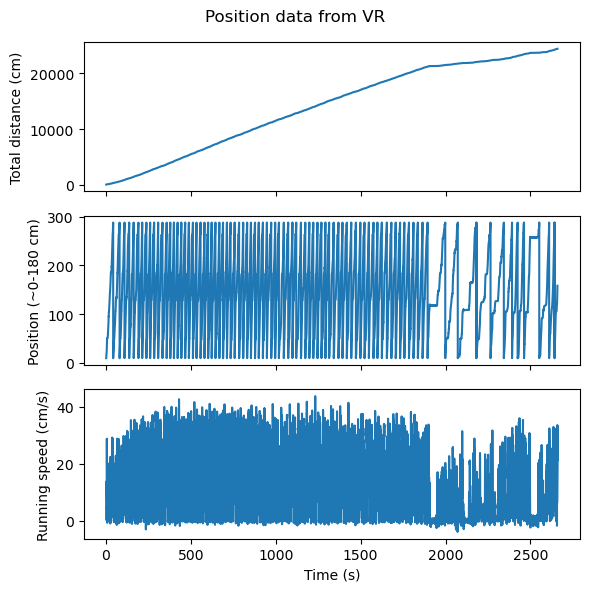

In [16]:
# VR position data
fig, ax = plt.subplots(3, 1, figsize=(6,6), sharex=True)
ax = ax.ravel()
fig.suptitle('Position data from VR')

ax[0].plot(times, total_dist)
ax[0].set_ylabel('Total distance (cm)')

ax[1].plot(times, position)
ax[1].set_ylabel('Position (~0-180 cm)')

ax[2].plot(times, speed)
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Running speed (cm/s)')

plt.tight_layout()

In [17]:
#### Calculate speed based on rotary encoder NIDAQ output 

# # Convert angular rotary encoder output to linear position
# diameter = 19.7
# ppr = 1000
# effective_ppr = ppr #* 4  # Already adjusted for quadrature decoding 
# linear_position = ci_data[:] / effective_ppr * np.pi * diameter 

# nidaq_total_dist = linear_position[behav_idx] - linear_position[behav_start_idx]
# nidaq_total_dist = nidaq_total_dist * options['base_tunnel']['speed_gain']

# # To account for the quantization effect, a moving average is used for speed calculation
# nidaq_speed = np.diff(nidaq_total_dist) / np.diff(behav_times) 
# dt = 1 / nidaq_sampling_rate
# nidaq_speed = np.diff(nidaq_total_dist) / dt
# nidaq_speed = np.append(nidaq_speed, nidaq_speed[-1])

# window_size = int(nidaq_sampling_rate / 60) # Use VR sampling rate (approx)
# nidaq_speed = uniform_filter1d(nidaq_speed, size=window_size, mode='nearest')

# nidaq_position = nidaq_total_dist + np.array(options['flip_tunnel']['margin_start'])
# nidaq_position = np.zeros(len(nidaq_total_dist))
# nidaq_position[0] = total_dist[0]
# for i in range(1, len(nidaq_total_dist)):
#    nidaq_position[i] = nidaq_position[i-1] + nidaq_total_dist[i] - nidaq_total_dist[i-1]
#    if nidaq_position[i] > options['flip_tunnel']['length']:  # reset to beginning of track
#         nidaq_position[i] -= options['flip_tunnel']['length']

# # NIDAQ position data 
# fig, ax2 = plt.subplots(3, 1, figsize=(6,6), sharex=True)
# ax2 = ax2.ravel()
# fig.suptitle('Position data from NIDAQ CI')

# shifted_behav_times = behav_times - behav_times[0]
# idx_plot = behav_idx - behav_idx[0]

# ax2[0].plot(shifted_behav_times, nidaq_total_dist[idx_plot])
# ax2[0].set_ylabel('Total distance (cm)') 

# ax2[1].plot(shifted_behav_times, nidaq_position[idx_plot])
# ax2[1].set_ylabel('Position (~0-180 cm)')

# ax2[2].plot(shifted_behav_times, nidaq_speed[idx_plot])
# ax2[2].set_xlabel('Time (s)')
# ax2[2].set_ylabel('Running speed (cm/s)')

# # ax[0].set_ylim(ax2[0].get_ylim())  
# # ax[1].set_ylim(ax2[1].get_ylim())  
# # ax[2].set_ylim(ax2[2].get_ylim())  

# print('Difference in total distance (VR - DAQ ctr) = ', (total_dist[-1] - total_dist[0]) - (nidaq_total_dist[-1] - nidaq_total_dist[0]))    # TODO: why and in what units?

# Plot an overlap of position determined from VR vs NIDAQ 
# plt.figure()
# plt.plot(times, total_dist, 'b-', label='VR')
# plt.plot(shifted_behav_times, nidaq_total_dist[idx_plot], 'c-', label='NIDAQ')
# plt.legend(loc='upper left')

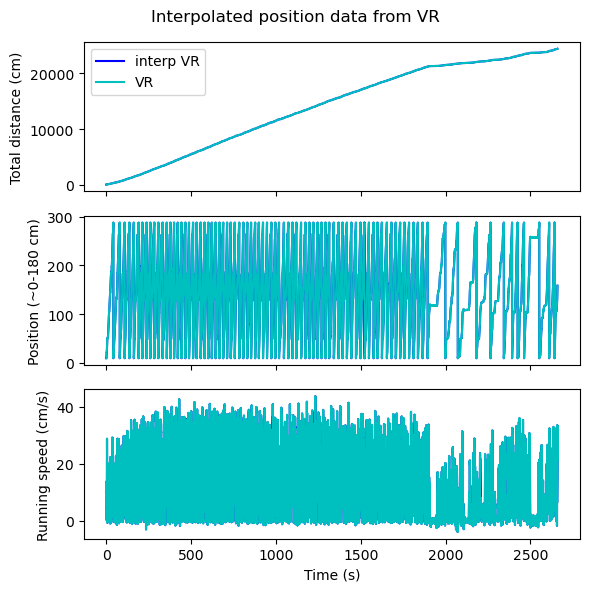

In [18]:
# Interpolate VR position
shifted_behav_times = behav_times - behav_times[0]

interp_total_dist = np.interp(shifted_behav_times, times, total_dist)

if num_laps == 1:
    interp_position = np.interp(shifted_behav_times, times, position)
else:
    period = int(np.round(position.max() - position.min()))  

    unwrapped_position = position.copy()
    for i in range(1, len(position)):
        diff = unwrapped_position[i] - unwrapped_position[i-1]
        if diff < -period / 2:
            unwrapped_position[i:] += period
        elif diff > period / 2:
            unwrapped_position[i:] -= period

    interp_unwrapped = np.interp(shifted_behav_times, times, unwrapped_position)
    interp_position = (interp_unwrapped - np.min(position)) % period + np.min(position)

interp_speed = np.interp(shifted_behav_times, times, speed)
# interp_speed = np.diff(interp_total_dist) / np.diff(shifted_behav_times)
# interp_speed = np.append(interp_speed, interp_speed[-1])

# Visually confirm interpolation makes sense
fig, ax = plt.subplots(3, 1, figsize=(6,6), sharex=True)
ax = ax.ravel()
fig.suptitle('Interpolated position data from VR')

ax[0].plot(shifted_behav_times, interp_total_dist, 'b-', label='interp VR')
ax[0].plot(times, total_dist, 'c-', label='VR')
ax[0].set_ylabel('Total distance (cm)')

ax[1].plot(shifted_behav_times, interp_position, 'b-', label='interp VR')
ax[1].plot(times, position, 'c-', label='VR')
ax[1].set_ylabel('Position (~0-180 cm)')

ax[2].plot(shifted_behav_times, interp_speed, 'b-', label='interp VR')
ax[2].plot(times, speed, 'c-', label='VR')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Running speed (cm/s)')

ax[0].legend(loc='upper left')
plt.tight_layout()

## Create output for further analysis

**TODO**: Add the behaviour videos

In [19]:
# Collect all data 
binary_rewards = ai_data[behav_idx,2] > 1
reward_idx = np.where(np.diff(binary_rewards.astype(int)) >= 1)[0] - 1
bin_reward = np.zeros_like(ai_data[behav_idx, 2])
bin_reward[reward_idx + 1] = 1  
reward_times = reward_idx / nidaq_sampling_rate 

binary_licks = ai_data[behav_idx,1] > 1  
lick_idx = np.where(np.diff(binary_licks.astype(int)) == 1)[0] - 1
bin_licks = np.zeros_like(ai_data[behav_idx,1])
bin_licks[lick_idx + 1] = 1
lick_times = lick_idx / nidaq_sampling_rate 

binary_modd1 = ai_data[behav_idx,4] > 1
modd1_idx = np.where(np.diff(binary_modd1.astype(int)) >= 1)[0] - 1
bin_modd1 = np.zeros_like(ai_data[behav_idx,4])
bin_modd1[modd1_idx + 1] = 1
modd1_times = modd1_idx / nidaq_sampling_rate

binary_modd2 = ai_data[behav_idx,5] > 1
modd2_idx = np.where(np.diff(binary_modd2.astype(int)) >= 1)[0] - 1
bin_modd2 = np.zeros_like(ai_data[behav_idx,5])
bin_modd2[modd2_idx + 1] = 1
modd2_times = modd2_idx / nidaq_sampling_rate

In [20]:
# Ensure data from NIDAQ and VR are consistent in length
# MODDs and landmarks visited 
print('Number of MODDs detected on NIDAQ: ', len(modd1_idx) + len(modd2_idx))
print('Number of landmarks visited: ', len(all_lms))
assert len(all_lms) >= len(modd1_idx) + len(modd2_idx), 'Some landmarks are missing...'

# Licks
binary_licks = ai_data[:,1] > 1  # Convert to binary: 0 (low) / 1 (high)
lick_idx_test = np.where(np.diff(binary_licks.astype(int)) == 1)[0] 
print('Number of all licks on NIDAQ: ', len(np.where(np.diff(ai_data[:,1]) >= 1)[0]))
print('Number of licks detected on NIDAQ during VR: ', len(lick_idx))
print('Number of licks on VR: ', len(lick_idx_vr))

# Rewards
print('Number of rewards detected on NIDAQ: ', len(reward_times))
print('Number of rewards on VR: ', len(rewards_VR) + len(assistant_reward_idx) + len(manual_reward_idx))

Number of MODDs detected on NIDAQ:  851
Number of landmarks visited:  875
Number of all licks on NIDAQ:  3866
Number of licks detected on NIDAQ during VR:  3766
Number of licks on VR:  16172
Number of rewards detected on NIDAQ:  157
Number of rewards on VR:  157


In [21]:
# Create arrays of data binned by imaging frames 
reward_array, _, _ = binned_statistic(behav_times, bin_reward, statistic='sum', bins=valid_frames_behav)

lick_array, _, _ = binned_statistic(behav_times, bin_licks, statistic='sum', bins=valid_frames_behav)

modd1_array, _, _ = binned_statistic(behav_times, bin_modd1, statistic='sum', bins=valid_frames_behav)

modd2_array, _, _ = binned_statistic(behav_times, bin_modd2, statistic='sum', bins=valid_frames_behav)

assert len(reward_array) == len(valid_frames_behav) - 1, 'Something is wrong with the binning.'

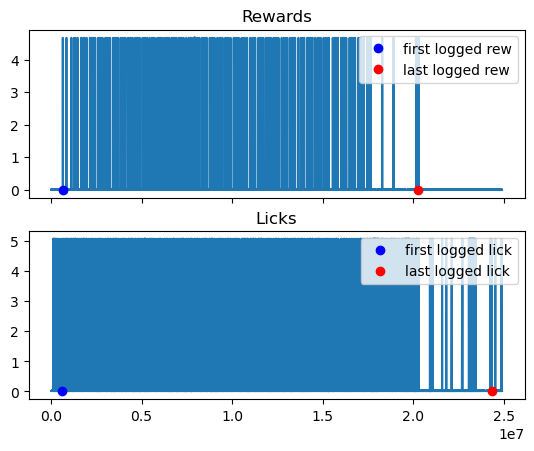

In [22]:
# Visually confirm the behaviour events during imaging

# REWARDS
first_idx_rew = np.where(np.array(reward_array) > 0)[0][0]
first_time_rew = valid_frames_behav[first_idx_rew]

last_idx_rew = np.where(np.array(reward_array) > 0)[0][-1]
last_time_rew = valid_frames_behav[last_idx_rew]

closest_time1_rew = behav_idx[np.argmin(np.abs(behav_times - first_time_rew))]
closest_time2_rew = behav_idx[np.argmin(np.abs(behav_times - last_time_rew))]

# LICKS
first_idx_licks = np.where(np.array(lick_array) > 0)[0][0]
first_time_licks = valid_frames_behav[first_idx_licks]

last_idx_licks = np.where(np.array(lick_array) > 0)[0][-1]
last_time_licks = valid_frames_behav[last_idx_licks]

closest_time1_licks = behav_idx[np.argmin(np.abs(behav_times - first_time_licks))]
closest_time2_licks = behav_idx[np.argmin(np.abs(behav_times - last_time_licks))]

# Plot
fig, ax = plt.subplots(2, 1, sharex=True)
ax = ax.ravel()

ax[0].plot(ai_data[:,2])
ax[0].plot(closest_time1_rew, 0, 'bo', label='first logged rew')
ax[0].plot(closest_time2_rew, 0, 'ro', label='last logged rew')
ax[0].legend(loc='upper right')
ax[0].title.set_text('Rewards')

ax[1].plot(ai_data[:,1])
ax[1].plot(closest_time1_licks, 0, 'bo', label='first logged lick')
ax[1].plot(closest_time2_licks, 0, 'ro', label='last logged lick')
ax[1].legend(loc='upper right')
ax[1].title.set_text('Licks')


875


Text(0.5, 0, 'Time (s)')

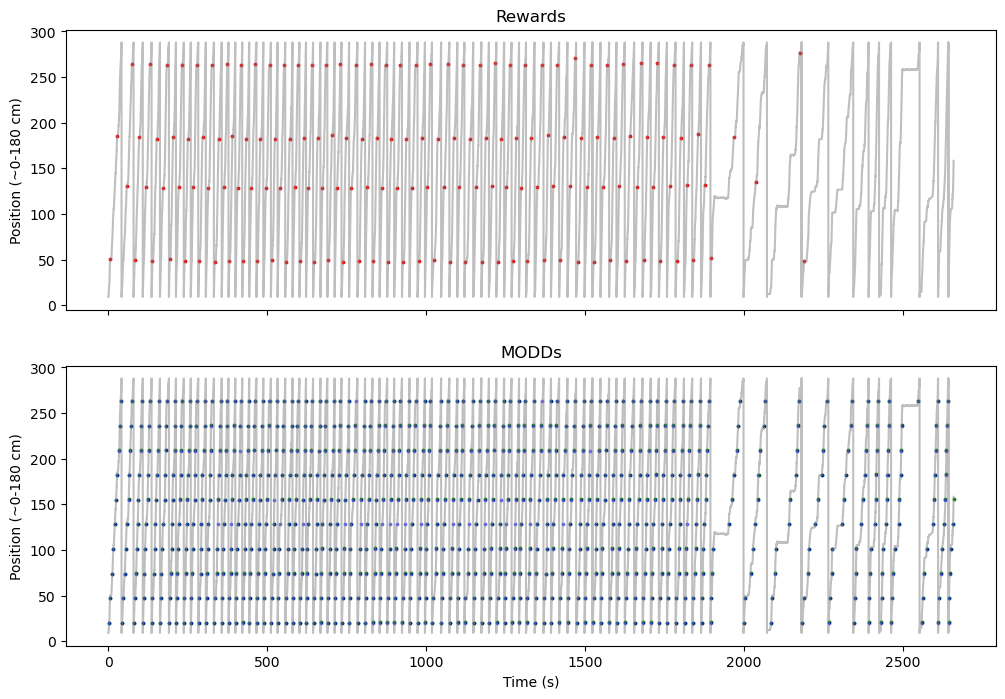

In [ ]:
# Plot rewards, MODDs and landmark entries superimposed on position
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True, sharey=True)
ax = ax.ravel()

# Rewards
ax[0].plot(shifted_behav_times, interp_position, 'gray', label='interp VR', alpha=0.5)
ax[0].scatter(reward_times, interp_position[reward_idx], s=3, color='r')
ax[0].set_ylabel('Position (~0-180 cm)')
ax[0].set_title('Rewards')

# MODDs and landmark entries
all_modd_times = np.sort(np.concatenate([modd1_times, modd2_times]))
all_modd_idx = np.sort(np.concatenate([modd1_idx, modd2_idx]))

# TODO: write function for this 
lm_entry_idx = []
if num_laps > 1:
    search_start = 0  

    for i, (lm_start, lm_end) in enumerate(all_landmarks):
        idx_candidates = np.where((interp_position[search_start:] >= lm_start) & (interp_position[search_start:] <= lm_end))[0]
        if len(idx_candidates) > 0:
            lm_entry_idx.append(idx_candidates[0] + search_start)
            search_start += idx_candidates[0] 
        else:
            print(f"Warning: no match found for landmark {i} with bounds {lm_start}-{lm_end}")
            lm_entry_idx.append(None)
else:
    for lm_start in all_landmarks[:,0]:
        lm_entry_idx.append(np.where(position >= lm_start)[0][0])

# print(len(np.array(lm_entry_idx)))

ax[1].plot(shifted_behav_times, interp_position, 'gray', label='interp VR', alpha=0.5)
ax[1].scatter(all_modd_times, interp_position[all_modd_idx], s=3, color='g')
ax[1].scatter(np.array(lm_entry_idx)/nidaq_sampling_rate, interp_position[lm_entry_idx], s=3, color='b', alpha=0.5)
ax[1].set_ylabel('Position (~0-180 cm)')
ax[1].set_title('MODDs')

ax[1].set_xlabel('Time (s)')

In [29]:
# Create arrays of position-related data binned by imaging frames 
speed_array, _, _ = binned_statistic(behav_times, interp_speed, statistic='mean', bins=valid_frames_behav)

position_array, _, _ = binned_statistic(behav_times, interp_position, statistic='mean', bins=valid_frames_behav)

total_dist_array, _, _ = binned_statistic(behav_times, interp_total_dist, statistic='mean', bins=valid_frames_behav)

assert len(speed_array) == len(valid_frames_behav) - 1, 'Something is wrong with the logged speed.'

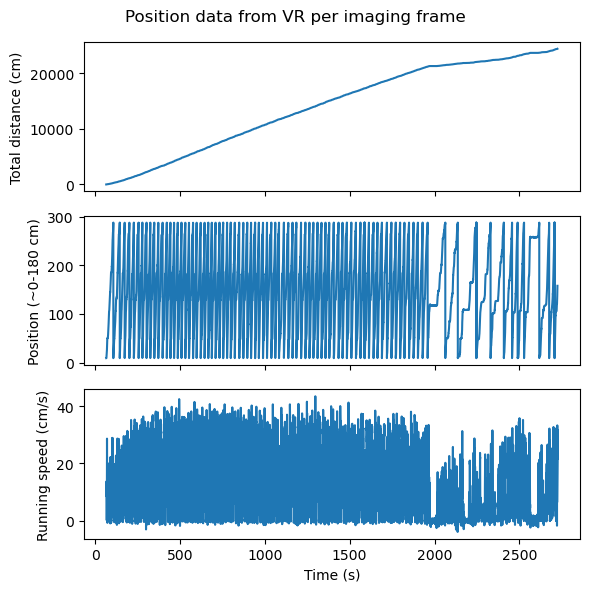

In [30]:
# Visually confirm the position data during imaging
window_size = 20    # arbitrary
# speed_array = uniform_filter1d(speed_array, size=window_size, mode='nearest')  # smoothing

fig, ax = plt.subplots(3, 1, figsize=(6,6), sharex=True)
ax = ax.ravel()
fig.suptitle('Position data from VR per imaging frame')

ax[0].plot(valid_frames_behav[:-1], total_dist_array)
ax[0].set_ylabel('Total distance (cm)')

ax[1].plot(valid_frames_behav[:-1], position_array)
ax[1].set_ylabel('Position (~0-180 cm)')

ax[2].plot(valid_frames_behav[:-1], speed_array)
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Running speed (cm/s)')
plt.tight_layout()

[  54.15749251   53.96435491   54.04056946   53.82118434 -215.95348392
   54.08964057   53.9268371    54.12616411   53.84383213 -215.912972
   54.06179978   54.04916854   53.93857844   54.17355214 -216.25777146
   53.93503878   54.13745368   54.30876913   53.87942103 -216.29377131
   54.14984027   53.88381143   54.01498843   54.20815315 -216.24476487
   54.2120849    53.77250208   54.51705631   53.70241634 -216.02214573
   54.14445602   53.651123     54.05551684   54.20640635 -215.75333843
   53.72677935   53.86708625   53.93216591   53.97295862 -215.9627938
   54.33702576   53.94873962   53.68776379   54.16038364 -215.70075719
   54.02566277   53.59267328   53.81260124   54.23360728 -215.53346091
   53.60033163   54.01935973   53.88658323   54.4687675  -216.14854186
   53.67088959   54.03077516   54.07659461   54.11075226 -216.0193739
   54.347483    107.43902931   54.19211519 -215.90820723   53.85541645
   53.90891141   54.1104379    54.00808008 -216.08014437   54.03732414
  107.7830

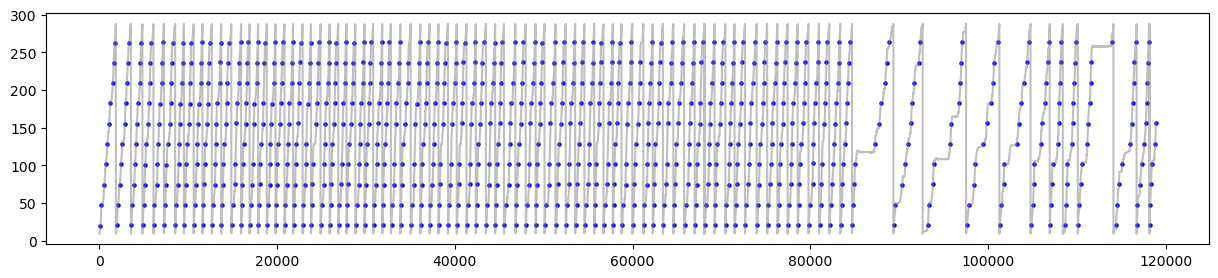

In [31]:
# Visually confirm consistent distance between MODDs
modd_idx = (np.concatenate([np.where(modd1_array == 1)[0], np.where(modd2_array == 1)[0]]))
modd1_positions = position_array[np.where(modd1_array == 1)[0]]
modd2_positions = position_array[np.where(modd2_array == 1)[0]]
if num_laps > 1:
    modd_positions = np.concatenate([modd1_positions, modd2_positions])
else:
    modd_positions = np.sort(np.concatenate([modd1_positions, modd2_positions]))

np.set_printoptions(threshold=np.inf)
print(np.diff(modd_positions))

# Plot the binned MODDs superimposed on binned position
plt.figure(figsize=(15,3))
plt.plot(position_array, color='gray', alpha=0.5)

plt.scatter(modd_idx, modd_positions, s=5, c='b')

In [32]:
# Add calcium traces 
spikes = np.load(os.path.join(sess_data_path, func_img_path, 'suite2p', 'plane0', 'spks.npy'))

# Keep spikes during behaviour 
behav_spikes = spikes[:, valid_frames_behav_idx]

In [33]:
# Save data
if save_npz: 
    np.savez_compressed(os.path.join(sess_data_path, 'behaviour_data.npz'), Ca_traces=behav_spikes, rewards=reward_array, licks=lick_array, \
             modd1=modd1_array, modd2=modd2_array, distance=total_dist_array, position=position_array, speed=speed_array)

if save_csv:  # Note spikes are not saved here - only behaviour
    df = pd.DataFrame({"Rewards": reward_array, "Licks": lick_array, "MODD1": modd1_array, "MODD2": modd2_array, \
                       "Distance": total_dist_array, "Position": position_array, "Speed": speed_array})
    df.to_csv(os.path.join(sess_data_path, 'behaviour_data.csv'), index=False)

np.savez_compressed(os.path.join(sess_data_path, 'valid_frames.npz'), valid_frames=valid_frames_behav_idx)